# Lab 4 -  Matrix Factorization

This notebook is to practice model based collaborative filtering approaches - Matrix factorization.

Please make sure you fill in any place that says YOUR CODE HERE or YOUR ANSWER HERE, as well as your name and ID below:

In [1]:
NAME = " "
ID = " "

## Matrix Factorization

Matrix factorization is a class of collaborative filtering models. Specifically, the model factorizes the user-item interaction matrix (e.g., rating matrix) into the product of two lower-rank matrices, capturing the low-rank structure of the user-item interactions.

The user-item interaction $\mathbf{R} \in \mathbb{R}^{m \times n}$ will be factorized into a user latent matrix $\mathbf{P} \in \mathbb{R}^{m \times k}$ and an item latent matrix $\mathbf{Q} \in \mathbb{R}^{n \times k}$, where $k \ll m, n$ , is the latent factor size.

$$ \hat{\mathbf{R}} = \mathbf{PQ}^\top $$

where $\hat{\mathbf{R}}\in \mathbb{R}^{m \times n}$ is the predicted rating matrix which has the same shape as $\mathbf{R} \in \mathbb{R}^{m \times n}$. An intuitive illustration of the matrix factorization model is shown below:



One major problem of this prediction rule is that users/items biases can not be modeled. For example, some users tend to give higher ratings or some items always get lower ratings due to poorer quality. These biases are common place in real-world applications. To capture these biases, user specific and item specific bias terms are introduced. Specifically, the predicted rating user $u$ gives to item $i$ is calculated by

$$\hat{\mathbf{R}}_{ui} = \mathbf{p}_u\mathbf{q}^\top_i + b_u + b_i + b$$

where $b$ is the global bias (which can be easily estimated by using the mean of all ratings), $b_u$ is the bias of user $u$, and $b_i$ is the bias of item $i$.  

Then, we train the matrix factorization model by minimizing the mean squared error between predicted rating scores and real rating scores. The objective function is defined as follows:

$$\underset{\mathbf{P}, \mathbf{Q}, b}{\mathrm{argmin}} \sum_{(u, i) \in \mathcal{K}} \| \mathbf{R}_{ui} -
\hat{\mathbf{R}}_{ui} \|^2 + \lambda (\| \mathbf{P} \|^2_F + \| \mathbf{Q}
\|^2_F + b_u^2 + b_i^2 )$$

where $\lambda$ denotes the regularization rate. The regularizing term $\lambda (\| \mathbf{P} \|^2_F + \| \mathbf{Q} \|^2_F + b_u^2 + b_i^2 )$ is used to avoid over-fitting by penalizing the magnitude of the parameters. The $(u, i)$ pairs for $\mathbf{R}_{ui}$ is known. The model parameters can be learned with an optimization algorithm, such as Stochastic Gradient Descent and Adam. 

The parameters unpdating could be realized as follows:
\begin{split}b_u &\leftarrow b_u &+ \gamma (e_{ui} - \lambda b_u)\\
b_i &\leftarrow b_i &+ \gamma (e_{ui} - \lambda b_i)\\
p_u &\leftarrow p_u &+ \gamma (e_{ui} \cdot q_i - \lambda p_u)\\
q_i &\leftarrow q_i &+ \gamma (e_{ui} \cdot p_u - \lambda q_i)\end{split}

where $e_{ui} = r_{ui} - \hat{r}_{ui}$ and $\gamma$ is learning rate.

You could find more explanations about matrix factorization algorithms [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#matrix-factorization-based-algorithms).

***
Now, we will introduce a simple implementation of matrix factorization using stochastic gradient descent algorithm.

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

class MF():
    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)  # shuffle its contents
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

We now try to apply it to a simple case: assume now we have 5 users and 4 items, and ratings are integers ranging from 1 to 5, the matrix may look something like:

In [3]:
R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

We call the train function to train the model, and output the predicted user-item matrix as well as related paramters.

In [4]:
mf = MF(R, K=2, alpha=0.1, beta=0.01, iterations=20)
training_process = mf.train()

print()
print("P x Q:", mf.full_matrix())
print()
print("P:",mf.P)
print()
print("Q:", mf.Q)
print()
print("Global bias:", mf.b)
print("User bias:", mf.b_u)
print("Item bias:", mf.b_i)

Iteration: 10 ; error = 0.2161
Iteration: 20 ; error = 0.0368

P x Q: [[4.98916147 2.99312736 4.53900688 1.01507762]
 [3.99326083 1.34298023 3.68800297 1.01215779]
 [1.00706026 1.00655422 2.41087859 4.98785986]
 [1.01262371 2.14771396 2.31690811 3.99688205]
 [5.01189897 1.01467096 4.98849784 3.99641   ]]

P: [[ 0.29331517 -1.34436174]
 [-0.28101506 -1.03589692]
 [-0.43318228  1.18249895]
 [ 0.39966335  0.87661578]
 [-1.4456727  -0.42568739]]

Q: [[-0.72247544 -1.36539089]
 [ 1.126307   -0.04412145]
 [-0.55480972 -0.58347931]
 [-0.76755735  1.76977663]]

Global bias: 2.769230769230769
User bias: [ 0.58913791 -0.40052716 -0.46768731 -0.27806344  0.60984897]
Item bias: [ 0.00712653 -0.75491943  0.55896505  0.26106515]


We could visualize the error between predicted rating scores and real rating scores.

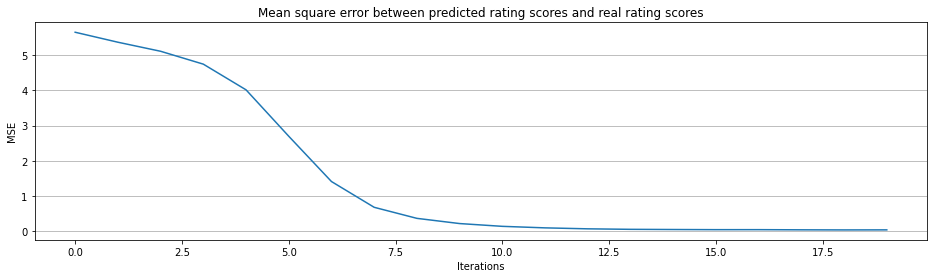

In [5]:
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
# plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title("Mean square error between predicted rating scores and real rating scores")
plt.grid(axis="y")

### Task 1

Your task is to predict user ratings for movieLen dataset by defined ``class MF()`` above. The small dataset (*movieLen_small_ratings.csv* in the data folder) of movie ratings contains 100,000 ratings of 9,000 movies by 600 users. You need to load the rating data and build a user-item matrix, on which you could apply the ``class MF()`` to make predictions. You should:
- 1. print the predicted rating arrays
- 2. plot the error between predicted rating scores and real rating scores.

In [6]:
### YOUR CODE HERE
# 1. please drop the movies and users whose rating counts are smaller than 5 
# 2. please make sure transform your dataframe to array (to_numpy()) to use class MF()
# 3. some possible choice for the hyper-parameters that you may try: K=20~50, alpha=0.0005~0.002 , beta=0.01~0.03, iterations=500~2000

###

In [29]:
import pandas as pd

movie_data = pd.read_csv("./data/movieLen_small_ratings.csv")
min_count = 5

#1. filter data 
need_del_item_data = movie_data.groupby("movieId").filter(lambda x: len(x) < min_count)
need_del_user_data = movie_data.groupby("userId").filter(lambda x: len(x) < min_count)
need_del_data = need_del_item_data.append(need_del_user_data)
movie_data = movie_data.drop(need_del_data.index).reset_index()

#initialization user-item matrix
R = pd.pivot_table(movie_data,index=['userId'],columns=['movieId'],values=['rating'],aggfunc=max,fill_value=0) 
print (R.values.shape)
R

/var/folders/vd/kvcvjynd7kz16m4fqk2mxglw0000gq/T/ipykernel_61035/4214014100.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  need_del_data = need_del_item_data.append(need_del_user_data)


(610, 3650)


rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
userId                                                                          
1          4.0    0.0    4.0    0.0    0.0    4.0    0.0      0    0.0    0.0   
2          0.0    0.0    0.0    0.0    0.0    0.0    0.0      0    0.0    0.0   
3          0.0    0.0    0.0    0.0    0.0    0.0    0.0      0    0.0    0.0   
4          0.0    0.0    0.0    0.0    0.0    0.0    0.0      0    0.0    0.0   
5          4.0    0.0    0.0    0.0    0.0    0.0    0.0      0    0.0    0.0   
...        ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
606        2.5    0.0    0.0    0.0    0.0    0.0    2.5      0    0.0    0.0   
607        4.0    0.0    0.0    0.0    0.0    0.0    0.0      0    0.0    0.0   
608        2.5    2.0    2.0    0.0    0.0    0.0    0.0      0    0.0    4.0   
609        3.0    0.0    0.0    0.0    0.0    0.0    0.0      0    0.0    4.0   
610        5.0    0.0    0.0    0.0    0.0    5.0    0.0      0    0.0    0.0   

         ...                                                                 \
movieId  ... 176371 177593 177765 179401 179819 180031 180985 183897 187593   
userId   ...                                                                  
1        ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2        ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3        ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4        ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5        ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
606      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
607      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
608      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
609      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
610      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                
movieId 187595  
userId          
1          0.0  
2          0.0  
3          0.0  
4          0.0  
5          0.0  
...        ...  
606        0.0  
607        0.0  
608        0.0  
609        0.0  
610        0.0  

[610 rows x 3650 columns]

Iteration: 10 ; error = 236.3606
Iteration: 20 ; error = 187.7867
Iteration: 10 ; error = 237.7720
Iteration: 20 ; error = 182.0267
Iteration: 10 ; error = 239.6001
Iteration: 20 ; error = 183.1710
Iteration: 10 ; error = 240.6947
Iteration: 20 ; error = 183.8109


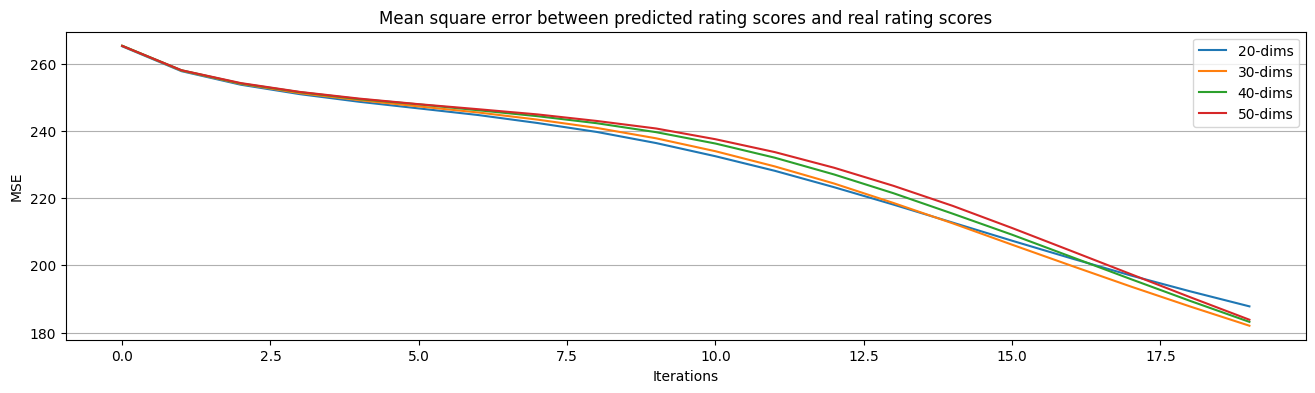

In [30]:
#training
K = [20, 30, 40, 50]

plt.figure(figsize=((16,4)))
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title("Mean square error between predicted rating scores and real rating scores")
plt.grid(axis="y")
for k in K:
    mf = MF(R.values, K=k, alpha=0.01, beta=0.01, iterations=20)
    training_process = mf.train()
    x = [x for x, y in training_process]
    y = [y for x, y in training_process]
    plt.plot(x, y, label='{}-dims'.format(k))
    plt.legend()
    

Iteration: 10 ; error = 273.1359
Iteration: 20 ; error = 265.0445
Iteration: 10 ; error = 265.0462
Iteration: 20 ; error = 257.6974
Iteration: 10 ; error = 237.8230
Iteration: 20 ; error = 182.2153
Iteration: 10 ; error = 184.6426
Iteration: 20 ; error = 121.1995


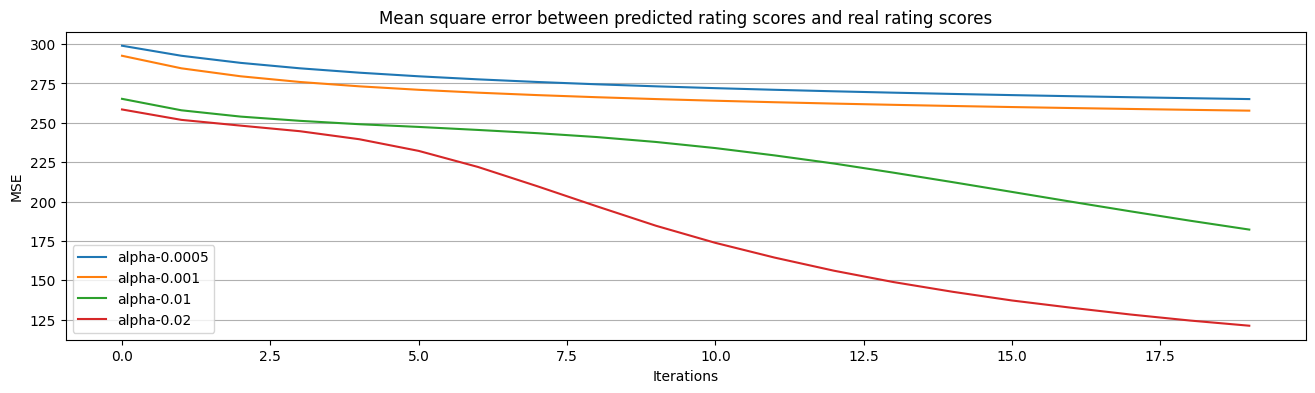

In [31]:
#use best k=30
alpha=[0.0005, 0.001, 0.01, 0.02]
plt.figure(figsize=((16,4)))
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title("Mean square error between predicted rating scores and real rating scores")
plt.grid(axis="y")
for lr in alpha:
    mf = MF(R.values, K=30, alpha=lr, beta=0.01, iterations=20)
    training_process = mf.train()
    x = [x for x, y in training_process]
    y = [y for x, y in training_process]
    plt.plot(x, y, label='alpha-{}'.format(lr))
    plt.legend()

Iteration: 10 ; error = 183.3791
Iteration: 20 ; error = 120.1957
Iteration: 10 ; error = 198.9837
Iteration: 20 ; error = 132.1261
Iteration: 10 ; error = 210.7176
Iteration: 20 ; error = 143.7303


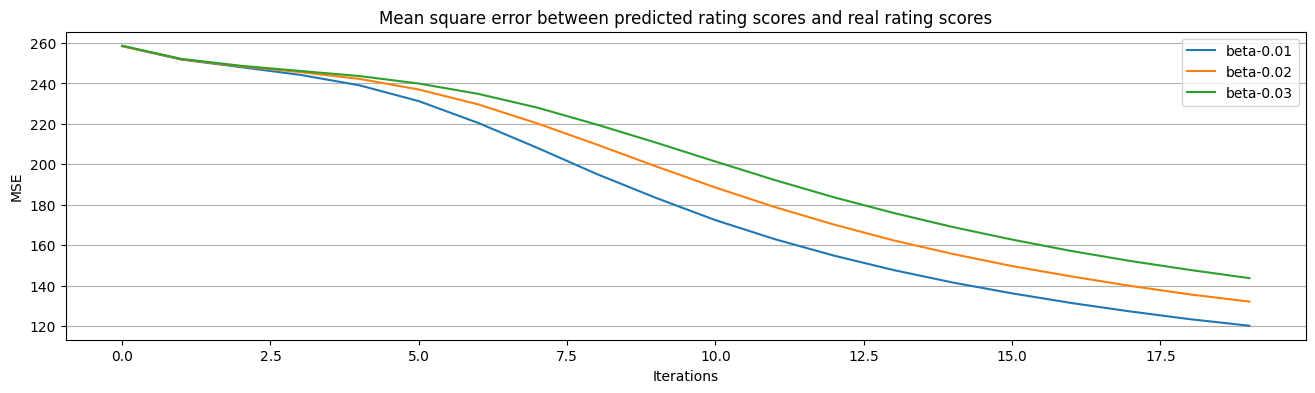

In [35]:
#use best k = 30, alpha = 0.02
beta = [0.01, 0.02, 0.03]
plt.figure(figsize=((16,4)))
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title("Mean square error between predicted rating scores and real rating scores")
plt.grid(axis="y")
for b in beta:
    mf = MF(R.values, K=30, alpha=0.02, beta=b, iterations=20)
    training_process = mf.train()
    x = [x for x, y in training_process]
    y = [y for x, y in training_process]
    plt.plot(x, y, label='beta-{}'.format(b))
    plt.legend()

In [38]:
#use best k = 30, alpha = 0.02, beta = 0.01, iterations=200
mf = MF(R.values, K=30, alpha=0.02, beta=0.01, iterations=200)
training_process = mf.train()
    

Iteration: 10 ; error = 183.5365
Iteration: 20 ; error = 120.7789
Iteration: 30 ; error = 101.0135
Iteration: 40 ; error = 92.1789
Iteration: 50 ; error = 87.2431
Iteration: 60 ; error = 83.9505
Iteration: 70 ; error = 81.6569
Iteration: 80 ; error = 79.9377
Iteration: 90 ; error = 78.5740
Iteration: 100 ; error = 77.5207
Iteration: 110 ; error = 76.4935
Iteration: 120 ; error = 75.6123
Iteration: 130 ; error = 74.9691
Iteration: 140 ; error = 74.6192
Iteration: 150 ; error = 74.0196
Iteration: 160 ; error = 73.5371
Iteration: 170 ; error = 73.1066
Iteration: 180 ; error = 72.8397
Iteration: 190 ; error = 72.5143
Iteration: 200 ; error = 72.3632


array([[4.87469443, 3.25656283, 4.20929943, ..., 4.88919371, 3.99279528,
        4.39632673],
       [3.63677075, 4.30926123, 4.66250763, ..., 4.51787561, 4.37801877,
        3.98922473],
       [2.39478661, 3.66546425, 1.08726099, ..., 2.2769094 , 1.801891  ,
        2.36882397],
       ...,
       [2.35894928, 2.08928026, 2.16407975, ..., 3.74958109, 3.56377493,
        3.33590912],
       [3.05797744, 2.12350227, 3.49026068, ..., 3.89990042, 4.13339311,
        3.485154  ],
       [4.03335707, 3.79937621, 3.58089366, ..., 3.81443429, 3.77771634,
        3.72295705]])

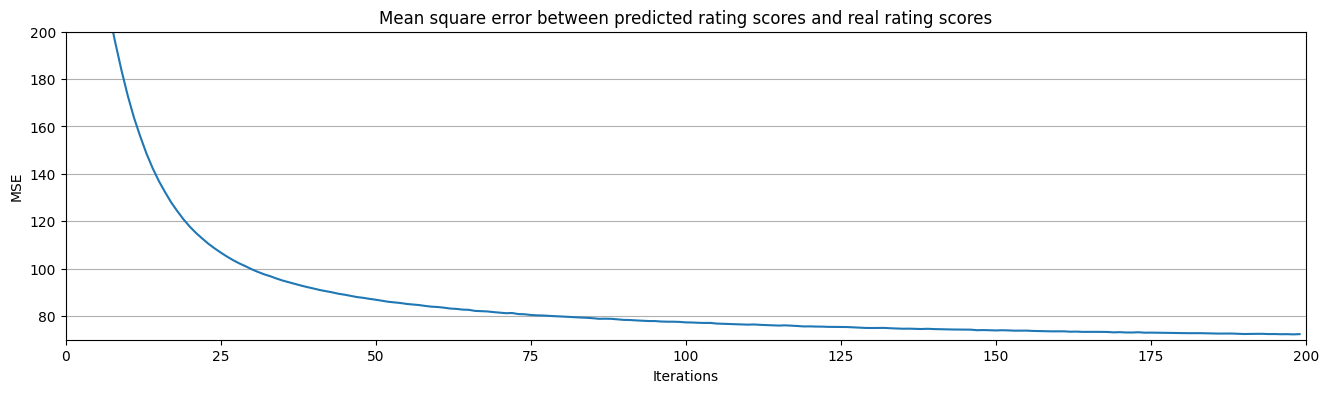

In [39]:
x = [x for x, y in training_process]
y = [y for x, y in training_process]

plt.figure(figsize=((16,4)))
plt.plot(x, y)
# plt.xticks(x, x)
plt.xlim((0, 200))
plt.ylim((70, 200))
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title("Mean square error between predicted rating scores and real rating scores")
plt.grid(axis="y")

#print predicted rating arrays
predict = np.zeros(R.shape)
for i in range(predict.shape[0]):
    for j in range(predict.shape[1]):
        predict[i, j] = mf.get_rating(i, j)
predict

## Surprise 
[Surprise](http://surpriselib.com/) library is a Python scikit for building and analyzing recommender systems that deal with explicit rating data. Surprise is the abbreviation of Simple Python Recommendation System Engine

It has a set of built-in algorithms and datasets for recommender systems. It provides various ready-to-use prediction algorithms such as baseline algorithms, neighborhood methods, matrix factorization-based ( SVD, PMF, SVD++, NMF), and many others. Also, various similarity measures (cosine, MSD, pearson…) are built-in.

In [15]:
# !pip install surprise

We use the *train_test_split()* to sample a trainset and a testset with given sizes, and use the accuracy metric of rmse. We’ll then use the *fit()* method which will train the algorithm on the trainset, and the *test()* method which will return the predictions made from the testset.

Here we use SVD++ algorithm, an extension of SVD taking into account implicit ratings.The prediction $\hat{\mathbf{R}}$ is set as:

$$\hat{\mathbf{R}}_{ui} = b + b_u + b_i + \mathbf{q}^\top_i\left(\mathbf{p}_u +|I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right)$$

Where the $y_j$ terms are a new set of item factors that capture implicit ratings. 

We can load build-in dataset by calling Dataset.load_builtin(), then use build_full_trainset() return a trainset from the whole dataset.

In [8]:
from surprise import SVDpp
from surprise import Dataset

# Load the movielens-100k dataset
data = Dataset.load_builtin('ml-100k')

# Retrieve the trainset.
trainset = data.build_full_trainset()

# Build an algorithm, and train it.
algo = SVDpp()
algo.fit(trainset)


In [9]:
trainset

We can now predict ratings by directly calling the predict() method.

In [10]:
uid = str(196)  # raw user id (as in the ratings file). They are **strings**!
iid = str(302)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=4, verbose=True)

user: 196        item: 302        r_ui = 4.00   est = 4.15   {'was_impossible': False}


In [11]:
# Get dataframe format of data.
import pandas as pd
df = pd.DataFrame(data.__dict__['raw_ratings'], columns=['user_id','item_id','rating','timestamp'])
df

,user_id,item_id,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596
...,...,...,...,...
99995,880,476,3.0,880175444
99996,716,204,5.0,879795543
99997,276,1090,1.0,874795795
99998,13,225,2.0,882399156


We now could build the rating matrix.

In [12]:
rating = pd.pivot_table(df, values='rating',index='user_id',columns='item_id')
rating = rating.fillna(0)
rating.head()

item_id,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


Make recommendations for a gvien user.

In [13]:
uid = str(196)  # raw user id (as in the ratings file). They are **strings**!

Score = []
Item_id = []
for iid in rating.index:
    if rating[uid][iid] == 0:
        pred = algo.predict(uid, iid, verbose=False)
        score = pred.est
        Item_id.append(iid)
        Score.append(score)
        
pred_df = pd.DataFrame({'item_id':Item_id, 'predicted_score': Score})
pred_df.head()

best_predictions = pred_df.sort_values(by='predicted_score',ascending=False)[:5]
best_predictions.head()

,item_id,predicted_score
248,408,4.549533
12,114,4.511940
65,169,4.491124
414,603,4.465142
306,480,4.441450


The surpise also provides more detail implementations, such as load_from_df( ), train_test_split( ), cross_validate( ), algo.fit(trainset).test(testset) to conduct more concrete operations.

### Task 2 (optional)

Your task is to predict user ratings for Book-Crossing dataset (*BX-Book-Ratings.csv* in the data folder) by adopting Surprise library. Given a user ID, you need to recommend 5 top books to the user.

In [14]:
### YOUR CODE HERE

###